In [1]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Lorenz System Parameters
sigma = 10.0        # σ parameter in Lorenz equations
rho = 28.0          # ρ parameter in Lorenz equations  
beta = 8.0/3.0      # β parameter in Lorenz equations

# Reservoir Computer Parameters
N = 100           # Number of reservoir neurons
P = 0.05            # Sparsity of internal connections (probability of connection)
rho_res = 0.6    # Spectral radius of reservoir matrix M
sigma_in = 0.2      # Input scaling parameter
gamma = 10.0        # Decay rate parameter
beta_ridge = 1e-4   # Ridge regression regularization parameter

# Time Parameters
dt = 0.01           # Integration time step
t_listen = 100.0    # Listening/washout time
t_train = 100.0     # Training time  
t_predict = 300.0   # Prediction time

# Initial Conditions
lorenz_ic = np.array([1.0, 1.0, 1.0])  # Lorenz initial condition

# Random seed for reproducibility
random_seed = 42


In [2]:

def lorenz_system(u, sigma, rho, beta):
    """
    Compute derivatives for the Lorenz attractor system.
    
    Args:
        u: Current state [x, y, z]
        sigma, rho, beta: Lorenz parameters
    
    Returns:
        du_dt: Derivatives [dx/dt, dy/dt, dz/dt]
    """
    x, y, z = u
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return np.array([dx_dt, dy_dt, dz_dt])


def reservoir_dynamics(r, u, M, W_in, gamma, sigma_in):
    """
    Compute derivatives for the reservoir system.
    
    Implements: dr/dt = -gamma * r + tanh(M @ r + sigma_in * W_in @ u)
    
    Args:
        r: Current reservoir state (N,)
        u: Input signal (3,)
        M: Internal connection matrix (N, N)
        W_in: Input connection matrix (N, 3)
        gamma: Decay rate parameter
        sigma_in: Input scaling parameter
    
    Returns:
        dr_dt: Reservoir state derivatives (N,)
    """
    internal_state = M @ r + sigma_in * W_in @ u
    dr_dt = gamma * ( -r + np.tanh(internal_state) )
    return dr_dt


def rk4_integrator(dynamics_func, state, dt, *args):
    """
    From-scratch 4th-order Runge-Kutta integrator.
    
    Args:
        dynamics_func: Function computing derivatives
        state: Current state vector
        dt: Time step
        *args: Additional arguments for dynamics_func
    
    Returns:
        new_state: Updated state after one RK4 step
    """
    k1 = dynamics_func(state, *args)
    k2 = dynamics_func(state + 0.5 * dt * k1, *args)
    k3 = dynamics_func(state + 0.5 * dt * k2, *args)
    k4 = dynamics_func(state + dt * k3, *args)
    
    new_state = state + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return new_state


def generate_reservoir_matrices(N, P, rho_res, seed=None):
    """
    Generate sparse reservoir matrix M and input matrix W_in.
    
    Args:
        N: Number of reservoir neurons
        P: Sparsity (probability of connection)
        rho_res: Desired spectral radius
        seed: Random seed for reproducibility
    
    Returns:
        M: Internal connection matrix (N, N)
        W_in: Input connection matrix (N, 3)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate sparse internal matrix M: (N, N)
    connections = np.random.rand(N, N) < P
    M = np.random.uniform(-1, 1, (N, N)) * connections
    
    # Scale to desired spectral radius
    eigenvals = np.linalg.eigvals(M)
    current_rho = np.max(np.abs(eigenvals))
    if current_rho > 0:
        M = M * (rho_res / current_rho)
    
    # Generate input matrix W_in: (N, 3)
    W_in = np.zeros((N, 3))
    for i in range(N):
        col_idx = np.random.randint(0, 3)
        W_in[i, col_idx] = np.random.uniform(-1, 1)
    
    return M, W_in


def state_augmentation(r):
    """
    Create augmented state q(r) = [r; r²] for readout.
    
    Args:
        r: Reservoir state (N,)
    
    Returns:
        q_r: Augmented state (2N,)
    """
    return np.concatenate([r, r**2])


def ridge_regression(X, Y, beta_ridge):
    """
    
    Implements: W_out = Y @ X.T @ inv(X @ X.T + beta_ridge * I)
    
    Args:
        X: Input data matrix (2N, num_train_steps)
        Y: Target data matrix (3, num_train_steps)
        beta_ridge: Regularization parameter
    
    Returns:
        W_out: Output weight matrix (3, 2N)
    """
    XXT = X @ X.T
    reg_matrix = XXT + beta_ridge * np.eye(XXT.shape[0])
    W_out = Y @ X.T @ np.linalg.inv(reg_matrix)
    return W_out

In [3]:
# ============================================================================
# PART 2: PHASE-BASED IMPLEMENTATION
# ============================================================================

def generate_lorenz_data(total_time, dt, initial_condition):
    """
    Generate Lorenz attractor trajectory data.
    
    Args:
        total_time: Total simulation time
        dt: Time step
        initial_condition: Initial state [x0, y0, z0]
    
    Returns:
        u_series: Lorenz trajectory (3, num_steps)
        time_array: Time points
    """
    print("Generating Lorenz attractor data...")
    
    num_steps = int(total_time / dt)
    u_series = np.zeros((3, num_steps))
    time_array = np.arange(0, total_time, dt)
    
    u_current = initial_condition.copy()
    
    for i in range(num_steps):
        u_series[:, i] = u_current
        u_current = rk4_integrator(lorenz_system, u_current, dt, sigma, rho, beta)
    
    print(f"Generated {num_steps} data points over {total_time} time units")
    return u_series, time_array


def listening_phase(u_series, M, W_in, t_listen, dt):
    """
    Phase 1: Listening/Washout Phase
    Drive reservoir with Lorenz data to eliminate initial transients.
    
    Args:
        u_series: Lorenz trajectory data (3, num_steps)
        M: Reservoir internal matrix
        W_in: Input connection matrix
        t_listen: Listening time duration
        dt: Time step
    
    Returns:
        r_final: Final reservoir state after washout
    """
    print("\n" + "="*60)
    print("PHASE 1: LISTENING/WASHOUT")
    print("="*60)
    print("Driving reservoir with Lorenz data to eliminate transients...")
    
    num_listen_steps = int(t_listen / dt)
    r_current = np.zeros(N)  # Start from zero state
    
    # Drive reservoir during listening phase - discard all states
    for i in range(num_listen_steps):
        u_input = u_series[:, i]
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt, 
                                 u_input, M, W_in, gamma, sigma_in)
    
    print(f"Listening phase completed over {t_listen} time units")
    print(f"Final reservoir state norm: {np.linalg.norm(r_current):.6f}")
    print("Initial transients eliminated - reservoir ready for training")
    
    return r_current


def training_phase(u_series, r_initial, M, W_in, t_listen, t_train, dt):
    """
    Phase 2: Training Phase
    Collect reservoir states and target data, then compute readout weights.
    
    Args:
        u_series: Lorenz trajectory data (3, num_steps)
        r_initial: Initial reservoir state from listening phase
        M: Reservoir internal matrix
        W_in: Input connection matrix
        t_listen: Listening time (for data indexing)
        t_train: Training time duration
        dt: Time step
    
    Returns:
        W_out: Trained readout matrix (3, 2N)
        r_final: Final reservoir state after training
    """
    print("\n" + "="*60)
    print("PHASE 2: TRAINING")
    print("="*60)
    print("Collecting reservoir states and computing readout weights...")
    
    num_listen_steps = int(t_listen / dt)
    num_train_steps = int(t_train / dt)
    
    # Initialize training data matrices
    X = np.zeros((2*N, num_train_steps))  # Augmented reservoir states
    Y = np.zeros((3, num_train_steps))    # Target Lorenz states
    
    r_current = r_initial.copy()
    
    # Collect training data
    print("Collecting training data...")
    for i in range(num_train_steps):
        idx = num_listen_steps + i
        u_input = u_series[:, idx]
        
        # State augmentation: q(r) = [r; r²]
        q_current = state_augmentation(r_current)
        X[:, i] = q_current
        Y[:, i] = u_input
        
        # Update reservoir state
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt, 
                                 u_input, M, W_in, gamma, sigma_in)
    
    # Compute readout weights using ridge regression
    print("Computing readout weights with ridge regression...")
    W_out = ridge_regression(X, Y, beta_ridge)
    
    # Calculate training error
    Y_pred_train = W_out @ X
    train_error = np.mean(np.linalg.norm(Y - Y_pred_train, axis=0))
    
    print(f"Training completed over {t_train} time units")
    print(f"Training RMSE: {train_error:.6f}")
    print(f"Readout matrix shape: {W_out.shape}")
    
    return W_out, r_current


def prediction_phase(r_initial, M, W_in, W_out, t_predict, dt):
    """
    Phase 3: Autonomous Prediction Phase
    Use trained reservoir to autonomously reconstruct Lorenz attractor.
    
    Args:
        r_initial: Initial reservoir state from training phase
        M: Reservoir internal matrix
        W_in: Input connection matrix
        W_out: Trained readout matrix
        t_predict: Prediction time duration
        dt: Time step
    
    Returns:
        u_pred: Predicted Lorenz trajectory (3, num_predict_steps)
        r_series: Reservoir state evolution (N, num_predict_steps)
    """
    print("\n" + "="*60)
    print("PHASE 3: AUTONOMOUS PREDICTION")
    print("="*60)
    print("Running autonomous reservoir to reconstruct Lorenz attractor...")
    
    num_predict_steps = int(t_predict / dt)
    
    # Initialize prediction arrays
    u_pred = np.zeros((3, num_predict_steps))
    r_series = np.zeros((N, num_predict_steps))
    
    r_current = r_initial.copy()
    
    # Autonomous prediction loop
    for i in range(num_predict_steps):
        # Store current reservoir state
        r_series[:, i] = r_current
        
        # State augmentation and prediction
        q_current = state_augmentation(r_current)
        u_hat = W_out @ q_current  # Prediction: u_hat(t) = W_out @ q(r(t))
        u_pred[:, i] = u_hat
        
        # Feed prediction back into reservoir (autonomous mode)
        r_current = rk4_integrator(reservoir_dynamics, r_current, dt, 
                                 u_hat, M, W_in, gamma, sigma_in)
    
    print(f"Autonomous prediction completed over {t_predict} time units")
    print("Lorenz attractor reconstruction finished")
    
    return u_pred, r_series


In [5]:
def analyze_reconstruction(u_true, u_pred, t_predict, dt):
    """
    Analyze the quality of Lorenz attractor reconstruction.
    
    Args:
        u_true: True Lorenz trajectory
        u_pred: Predicted Lorenz trajectory  
        t_predict: Prediction time duration
        dt: Time step
    
    Returns:
        analysis_results: Dictionary with error metrics
    """
    print("\n" + "="*60)
    print("RECONSTRUCTION ANALYSIS")
    print("="*60)
    
    num_predict_steps = int(t_predict / dt)
    
    # Calculate prediction error
    pred_error = np.mean(np.linalg.norm(u_true[:, :num_predict_steps] - u_pred, axis=0))
    
    # Short-term prediction accuracy (first 50 time units)
    short_steps = min(int(50 / dt), num_predict_steps)
    short_error = np.mean(np.linalg.norm(u_true[:, :short_steps] - u_pred[:, :short_steps], axis=0))
    
    print(f"Overall prediction RMSE: {pred_error:.6f}")
    print(f"Short-term prediction RMSE (first {short_steps*dt:.1f}s): {short_error:.6f}")
    
    # Assess reconstruction quality
    if short_error < 1.0:
        print("\n✓ RECONSTRUCTION SUCCESSFUL!")
        print("  Reservoir has successfully learned the Lorenz attractor dynamics")
    else:
        print("\n✗ Reconstruction needs improvement")
        print("  Consider adjusting reservoir parameters")
    
    return {
        'overall_error': pred_error,
        'short_term_error': short_error,
        'success': short_error < 1.0
    }
    
def visualize_results(u_true, u_pred, t_listen, t_train, t_predict, dt):
    """
    Create comprehensive visualization of reconstruction results.
    
    Args:
        u_true: True Lorenz trajectory
        u_pred: Predicted Lorenz trajectory
        t_listen, t_train, t_predict: Phase durations
        dt: Time step
    """
    print("\nGenerating visualization...")
    
    num_listen_steps = int(t_listen / dt)
    num_train_steps = int(t_train / dt)
    num_predict_steps = int(t_predict / dt)
    
    # Training phase data
    train_start = num_listen_steps
    train_end = num_listen_steps + num_train_steps
    
    # Create visualization
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: Training Phase - 3D Attractor
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.plot(u_true[0, train_start:train_end], 
             u_true[1, train_start:train_end], 
             u_true[2, train_start:train_end], 
             'orange', alpha=0.8, linewidth=1.5, label='True Lorenz')
    
    ax1.set_title('Training Phase: True Lorenz Attractor', fontsize=12)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()
    
    # Plot 2: Prediction Phase - 3D Reconstruction
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :], 
             'darkblue', alpha=0.8, linewidth=1.5, label='Reconstructed')
    
    ax2.set_title('Prediction Phase: Reconstructed Attractor', fontsize=12)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.legend()
    
# Plot 3: Overlay Comparison - Both True and Reconstructed
    ax3 = fig.add_subplot(233, projection='3d')

# Plot true Lorenz attractor (from training phase for reference)
    train_start = num_listen_steps
    train_end = num_listen_steps + num_train_steps
    ax3.plot(u_true[0, train_start:train_end], 
         u_true[1, train_start:train_end], 
         u_true[2, train_start:train_end], 
         'orange', alpha=0.6, linewidth=1.5, label='True Lorenz')

# Plot reconstructed attractor
    ax3.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :], 
         'darkblue', alpha=0.7, linewidth=1.5, label='Reconstructed')

    ax3.set_title('True vs Reconstructed Overlay', fontsize=12)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.legend()
    
    # Plot 4: Short-term Time Series (X component)
    ax4 = fig.add_subplot(234)
    short_steps = min(500, num_predict_steps)  # First 5 seconds
    t_short = np.arange(short_steps) * dt
    
    if u_true.shape[1] > train_end + short_steps:
        pred_start = train_end
        ax4.plot(t_short, u_true[0, pred_start:pred_start+short_steps], 
                 'orange', linewidth=2, label='True X', alpha=0.8)
    
    ax4.plot(t_short, u_pred[0, :short_steps], 
             'darkblue', linewidth=2, label='Reconstructed X', alpha=0.8)
    
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('X coordinate')
    ax4.set_title(f'Short-term Comparison (first {short_steps*dt:.1f}s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Long-term Time Series (X component)  
    ax5 = fig.add_subplot(235)
    t_pred = np.arange(num_predict_steps) * dt
    
    ax5.plot(t_pred, u_pred[0, :], 'darkblue', 
             linewidth=1, label='Reconstructed X', alpha=0.8)
    
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('X coordinate')
    ax5.set_title(f'Long-term Reconstruction ({t_predict:.1f}s)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Spectral Radius Visualization
    ax6 = fig.add_subplot(236)
    
    # This would require M from main function - placeholder for now
    ax6.text(0.5, 0.5, f'Reservoir Parameters:\n\nN = {N}\nρ = {rho_res}\nσ = {sigma_in}\nγ = {gamma}', 
             transform=ax6.transAxes, fontsize=12, ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax6.set_title('Reservoir Configuration')
    ax6.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Plot 6: Overlapping True vs Reconstructed Attractor
    ax6 = fig.add_subplot(236, projection='3d')

    # Plot true Lorenz (training portion)
    train_start = num_listen_steps
    train_end = num_listen_steps + num_train_steps
    ax6.plot(u_true[0, train_start:train_end], 
            u_true[1, train_start:train_end], 
            u_true[2, train_start:train_end], 
            'orange', alpha=0.7, linewidth=1.5, label='True Lorenz')

    # Plot reconstructed attractor
    ax6.plot(u_pred[0, :], u_pred[1, :], u_pred[2, :], 
         'darkblue', alpha=0.7, linewidth=1.5, label='Reconstructed')

    ax6.set_title('True vs Reconstructed Overlay', fontsize=12)
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')
    ax6.set_zlabel('Z')
    ax6.legend()

    
def plot_spectral_analysis(M, rho_res):
    """
    Create spectral radius visualization showing eigenvalues of reservoir matrix.
    
    Args:
        M: Reservoir internal matrix
        rho_res: Target spectral radius
    """
    print("Generating spectral analysis plot...")
    
    # Calculate eigenvalues of M
    eigenvals = np.linalg.eigvals(M)
    actual_rho = np.max(np.abs(eigenvals))
    
    # Create spectral radius plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Plot eigenvalues in complex plane
    ax.scatter(eigenvals.real, eigenvals.imag, c='darkgreen', alpha=0.6, s=20, 
               label=f'Eigenvalues (N={len(eigenvals)})')
    
    # Draw target spectral radius circle
    theta = np.linspace(0, 2*np.pi, 100)
    target_circle_real = rho_res * np.cos(theta)
    target_circle_imag = rho_res * np.sin(theta)
    ax.plot(target_circle_real, target_circle_imag, 'r--', linewidth=2, 
            label=f'Target ρ = {rho_res}')
    
    # Draw actual spectral radius circle
    actual_circle_real = actual_rho * np.cos(theta)
    actual_circle_imag = actual_rho * np.sin(theta)
    ax.plot(actual_circle_real, actual_circle_imag, 'b-', linewidth=2, 
            label=f'Actual ρ = {actual_rho:.4f}')
    
    # Add unit circle for reference
    ax.plot(np.cos(theta), np.sin(theta), 'k:', linewidth=1, alpha=0.5, 
            label='Unit Circle')
    
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')
    ax.set_title('Reservoir Matrix Spectral Analysis')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Add text box with statistics
    textstr = f'''Spectral Statistics:
Target ρ: {rho_res}
Actual ρ: {actual_rho:.4f}
Matrix Size: {M.shape[0]}×{M.shape[1]}
Sparsity: {P:.1%}
Non-zero Elements: {np.count_nonzero(M)}'''
    
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout(w_pad=0.3,h_pad=0.2)
    plt.show()
    plt.savefig(str('N_Vs_Rho.pdf'),transparent=True,bbox_inches='tight')
    
    print(f"Spectral analysis completed:")
    print(f"  Target spectral radius: {rho_res}")
    print(f"  Actual spectral radius: {actual_rho:.6f}")
    print(f"  Scaling accuracy: {(actual_rho/rho_res)*100:.2f}%")

Lorenz Attractor Reconstruction using Reservoir Computing
Three-Phase Implementation
INITIALIZATION
------------------------------
Generating reservoir matrices (N=100, P=0.05, ρ=0.6)
Generating Lorenz attractor data...
Generated 50000 data points over 500.0 time units
Data structures initialized:
  u_series shape: (3, 50000)
  M shape: (100, 100)
  W_in shape: (100, 3)

PHASE 1: LISTENING/WASHOUT
Driving reservoir with Lorenz data to eliminate transients...
Listening phase completed over 100.0 time units
Final reservoir state norm: 4.991368
Initial transients eliminated - reservoir ready for training

PHASE 2: TRAINING
Computing readout weights with ridge regression...
Training completed over 100.0 time units
Training RMSE: 0.007399
Readout matrix shape: (3, 200)

PHASE 3: AUTONOMOUS PREDICTION
Running autonomous reservoir to reconstruct Lorenz attractor...
Autonomous prediction completed over 300.0 time units
Lorenz attractor reconstruction finished

RECONSTRUCTION ANALYSIS
Overall p

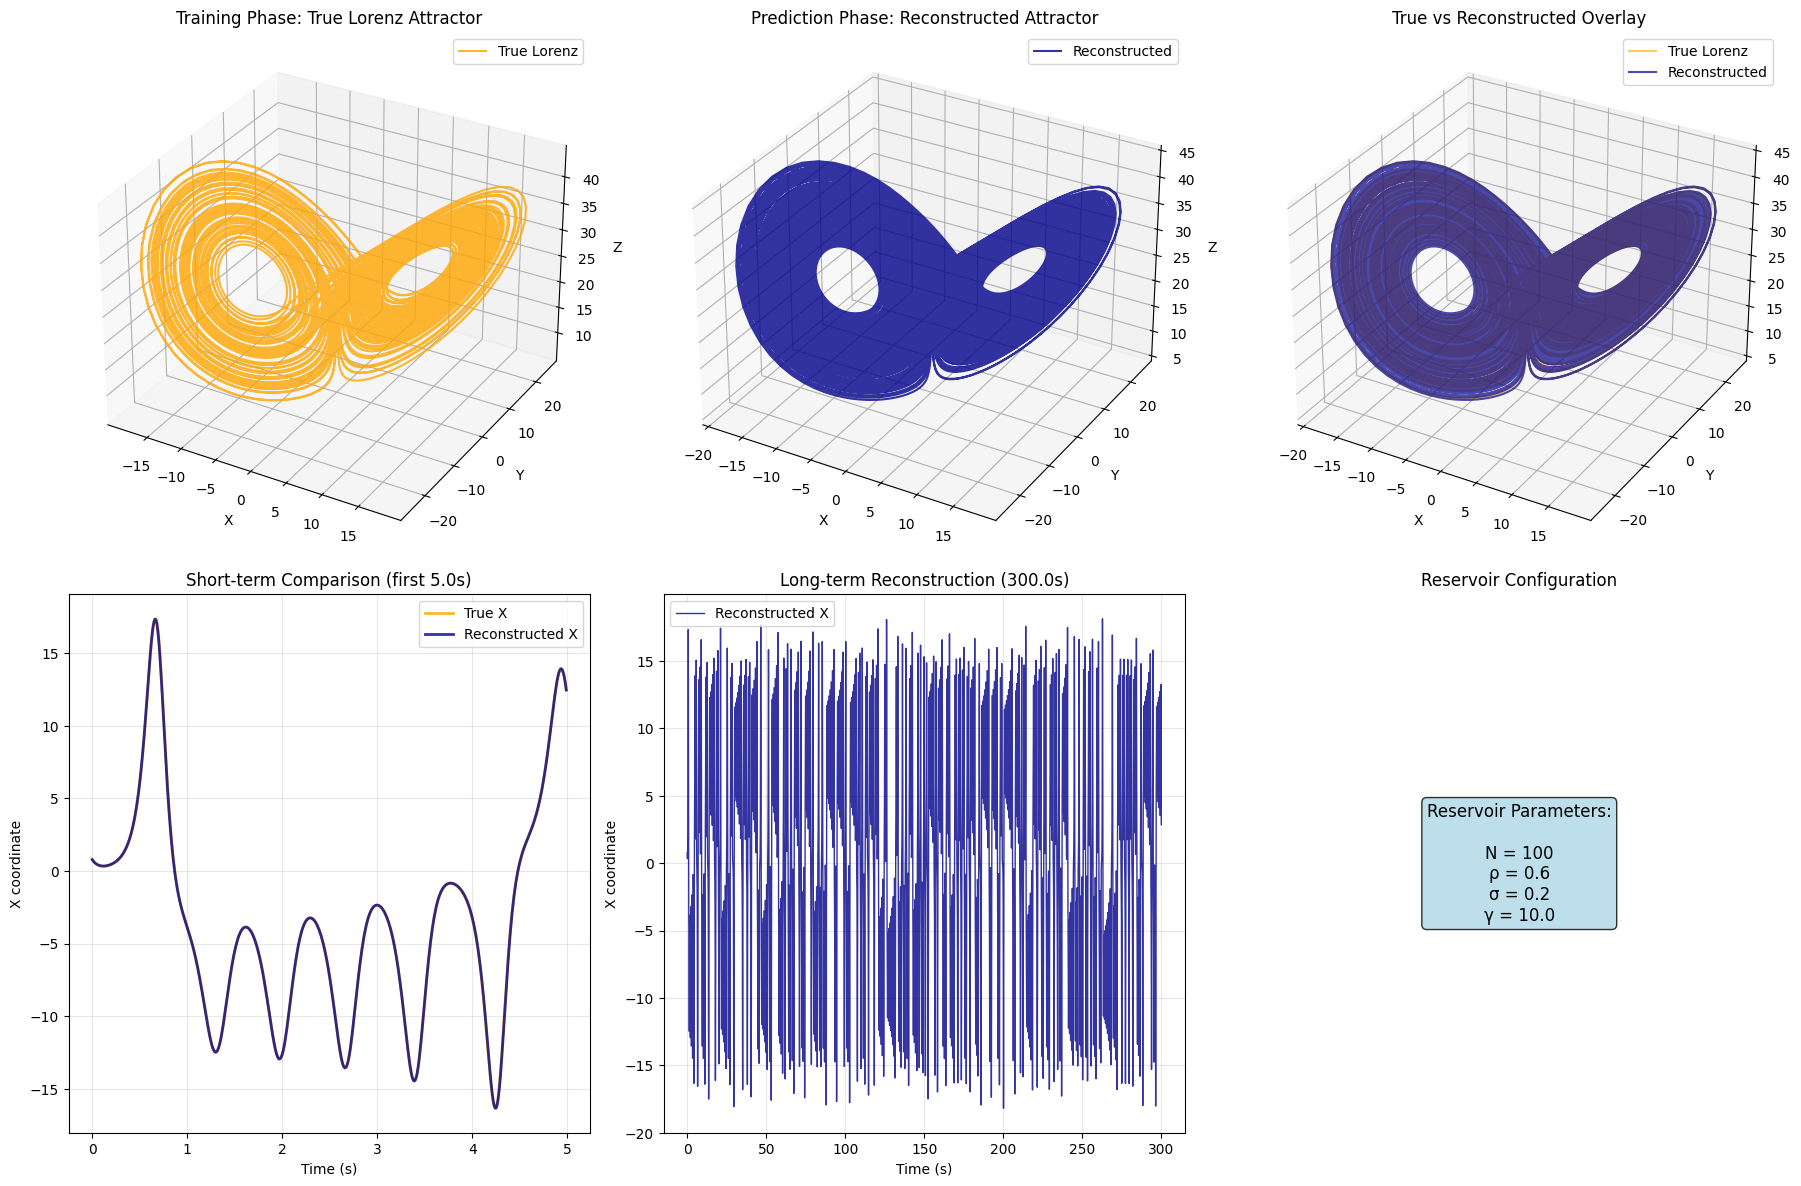

Generating spectral analysis plot...


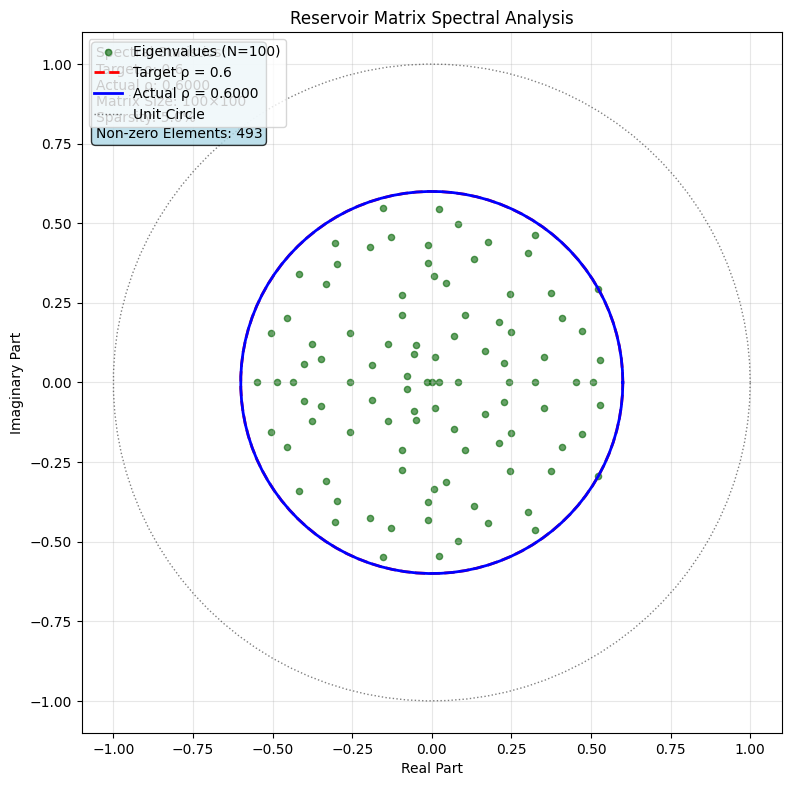

Spectral analysis completed:
  Target spectral radius: 0.6
  Actual spectral radius: 0.600000
  Scaling accuracy: 100.00%

RECONSTRUCTION SUMMARY
Reservoir Configuration:
  Size (N): 100
  Spectral radius (ρ): 0.6
  Input scaling (σ): 0.2
  Decay rate (γ): 10.0

Phase Durations:
  Listening: 100.0 time units
  Training: 100.0 time units
  Prediction: 300.0 time units

Results:
  Overall RMSE: 17.969844
  Short-term RMSE: 18.094618
  Success: ✗

⚠️  Reconstruction needs improvement.
   Consider adjusting: rho_res, sigma_in, gamma, or N


In [5]:

def main():
    """
    Main execution function implementing the complete three-phase RC pipeline.
    
    This function orchestrates the entire Lorenz attractor reconstruction process:
    1. Generate Lorenz data and reservoir matrices
    2. Execute listening phase (washout)
    3. Execute training phase (data collection + ridge regression)
    4. Execute prediction phase (autonomous reconstruction)
    5. Analyze and visualize results
    """
    print("Lorenz Attractor Reconstruction using Reservoir Computing")
    print("Three-Phase Implementation")
    print("=" * 70)
    
    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # ========================================================================
    # INITIALIZATION
    # ========================================================================
    
    print("INITIALIZATION")
    print("-" * 30)
    
    # Generate reservoir matrices
    print(f"Generating reservoir matrices (N={N}, P={P}, ρ={rho_res})")
    M, W_in = generate_reservoir_matrices(N, P, rho_res, random_seed)
    
    # Generate Lorenz attractor data for all phases
    total_time = t_listen + t_train + t_predict
    u_series, time_array = generate_lorenz_data(total_time, dt, lorenz_ic)
    
    print(f"Data structures initialized:")
    print(f"  u_series shape: {u_series.shape}")
    print(f"  M shape: {M.shape}")
    print(f"  W_in shape: {W_in.shape}")
    
    # ========================================================================
    # PHASE 1: LISTENING (WASHOUT)
    # ========================================================================
    
    r_after_listening = listening_phase(u_series, M, W_in, t_listen, dt)
    
    # ========================================================================
    # PHASE 2: TRAINING
    # ========================================================================
    
    W_out, r_after_training = training_phase(u_series, r_after_listening, 
                                            M, W_in, t_listen, t_train, dt)
    
    # ========================================================================
    # PHASE 3: PREDICTION
    # ========================================================================
    
    u_pred, r_series = prediction_phase(r_after_training, M, W_in, W_out, 
                                       t_predict, dt)
    
    # ========================================================================
    # ANALYSIS AND VISUALIZATION
    # ========================================================================
    
    # Analyze reconstruction quality
    analysis_results = analyze_reconstruction(u_series, u_pred, t_predict, dt)
    
    # Create comprehensive visualization
    visualize_results(u_series, u_pred, t_listen, t_train, t_predict, dt)

    plot_spectral_analysis(M, rho_res)
    
    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    
    print("\n" + "=" * 70)
    print("RECONSTRUCTION SUMMARY")
    print("=" * 70)
    print(f"Reservoir Configuration:")
    print(f"  Size (N): {N}")
    print(f"  Spectral radius (ρ): {rho_res}")
    print(f"  Input scaling (σ): {sigma_in}")
    print(f"  Decay rate (γ): {gamma}")
    print(f"")
    print(f"Phase Durations:")
    print(f"  Listening: {t_listen} time units")
    print(f"  Training: {t_train} time units") 
    print(f"  Prediction: {t_predict} time units")
    print(f"")
    print(f"Results:")
    print(f"  Overall RMSE: {analysis_results['overall_error']:.6f}")
    print(f"  Short-term RMSE: {analysis_results['short_term_error']:.6f}")
    print(f"  Success: {'✓' if analysis_results['success'] else '✗'}")
    
    if analysis_results['success']:
        print(f"\n🎉 Lorenz attractor reconstruction SUCCESSFUL!")
        print(f"   The reservoir computer has learned to autonomously")
        print(f"   reconstruct the chaotic Lorenz attractor dynamics!")
    else:
        print(f"\n⚠️  Reconstruction needs improvement.")
        print(f"   Consider adjusting: rho_res, sigma_in, gamma, or N")
    
    return {
        'u_series': u_series,
        'u_pred': u_pred,
        'r_series': r_series,
        'W_out': W_out,
        'M': M,
        'W_in': W_in,
        'analysis': analysis_results
    }


# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    results = main()

\n================================================================================
STARTING EXPERIMENT: N = 100, rho_res = 1.2
================================================================================\n
Generating Lorenz attractor data...
Generated 50000 data points over 500.0 time units

PHASE 1: LISTENING/WASHOUT
Driving reservoir with Lorenz data to eliminate transients...
Listening phase completed over 100.0 time units
Final reservoir state norm: 6.298012
Initial transients eliminated - reservoir ready for training

PHASE 2: TRAINING
Computing readout weights with ridge regression...
Training completed over 100.0 time units
Training RMSE: 0.008760
Readout matrix shape: (3, 200)

PHASE 3: AUTONOMOUS PREDICTION
Running autonomous reservoir to reconstruct Lorenz attractor...
Autonomous prediction completed over 300.0 time units
Lorenz attractor reconstruction finished


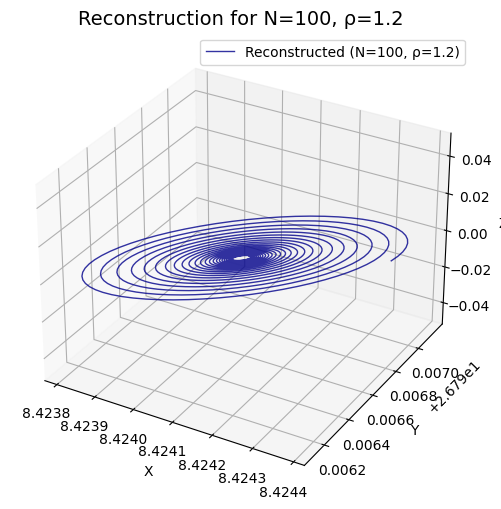

\n--- EXPERIMENT COMPLETE: N = 100, rho_res = 1.2 ---\n
\n================================================================================
STARTING EXPERIMENT: N = 100, rho_res = 1.5
================================================================================\n
Generating Lorenz attractor data...
Generated 50000 data points over 500.0 time units

PHASE 1: LISTENING/WASHOUT
Driving reservoir with Lorenz data to eliminate transients...
Listening phase completed over 100.0 time units
Final reservoir state norm: 6.792392
Initial transients eliminated - reservoir ready for training

PHASE 2: TRAINING
Computing readout weights with ridge regression...
Training completed over 100.0 time units
Training RMSE: 0.015267
Readout matrix shape: (3, 200)

PHASE 3: AUTONOMOUS PREDICTION
Running autonomous reservoir to reconstruct Lorenz attractor...
Autonomous prediction completed over 300.0 time units
Lorenz attractor reconstruction finished


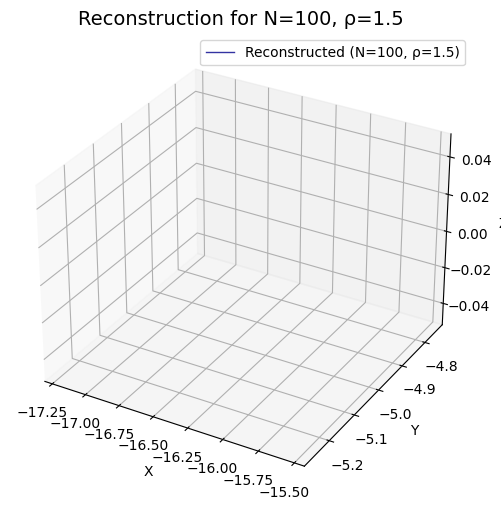

\n--- EXPERIMENT COMPLETE: N = 100, rho_res = 1.5 ---\n
\n********************************************************************************
Hyperparameter sweep finished in 7.62 seconds.
********************************************************************************\n


In [12]:
import time

def run_experiment(N_val, rho_res_val):
    """
    Encapsulates a single run of the Lorenz attractor reconstruction
    with specified N and rho_res.
    """
    print(f"\\n{'='*80}")
    print(f"STARTING EXPERIMENT: N = {N_val}, rho_res = {rho_res_val}")
    print(f"{'='*80}\\n")

    global N, rho_res 
    N = N_val
    rho_res = rho_res_val

    # 1. Initialization
    M, W_in = generate_reservoir_matrices(N, P, rho_res, random_seed)
    total_time = t_listen + t_train + t_predict
    u_series, _ = generate_lorenz_data(total_time, dt, lorenz_ic)

    # 2. Listening (Washout)
    r_after_listening = listening_phase(u_series, M, W_in, t_listen, dt)

    # 3. Training
    W_out, r_after_training = training_phase(u_series, r_after_listening,
                                            M, W_in, t_listen, t_train, dt)

    # 4. Prediction
    u_pred, _ = prediction_phase(r_after_training, M, W_in, W_out,
                                 t_predict, dt)

    # 5. Visualization 
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(u_pred[0, -1500:], u_pred[2, -1500:],
             'darkblue', alpha=0.8, linewidth=1.0, label=f'Reconstructed (N={N_val}, ρ={rho_res_val})')
    ax.set_title(f'Reconstruction for N={N_val}, ρ={rho_res_val}', fontsize=14)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

    print(f"\\n--- EXPERIMENT COMPLETE: N = {N_val}, rho_res = {rho_res_val} ---\\n")


# ============================================================================
# MAIN HYPERPARAMETER SWEEP
# ============================================================================

if __name__ == "__main__":
    
    N_values = [ 100]
    rho_res_values = [ 1.2, 1.5]

    start_time = time.time()

    # Loop through all combinations
    for n_val in N_values:
        for rho_val in rho_res_values:
            run_experiment(n_val, rho_val)

    end_time = time.time()
    print(f"\\n{'*'*80}")
    print(f"Hyperparameter sweep finished in {end_time - start_time:.2f} seconds.")
    print(f"{'*'*80}\\n")


Running for: N = 10, ρ = 1.2...
Generating Lorenz attractor data...
Generated 50000 data points over 500.0 time units

PHASE 1: LISTENING/WASHOUT
Driving reservoir with Lorenz data to eliminate transients...
Listening phase completed over 100.0 time units
Final reservoir state norm: 1.057855
Initial transients eliminated - reservoir ready for training

PHASE 2: TRAINING
Computing readout weights with ridge regression...
Training completed over 100.0 time units
Training RMSE: 1.250825
Readout matrix shape: (3, 20)

PHASE 3: AUTONOMOUS PREDICTION
Running autonomous reservoir to reconstruct Lorenz attractor...
Autonomous prediction completed over 300.0 time units
Lorenz attractor reconstruction finished
Running for: N = 10, ρ = 1.5...
Generating Lorenz attractor data...
Generated 50000 data points over 500.0 time units

PHASE 1: LISTENING/WASHOUT
Driving reservoir with Lorenz data to eliminate transients...
Listening phase completed over 100.0 time units
Final reservoir state norm: 1.0578

/var/folders/2t/_bg026bx1w9flrz2j8j9q5s40000gn/T/ipykernel_34315/438684097.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(w_pad=0.3,h_pad=0.2)


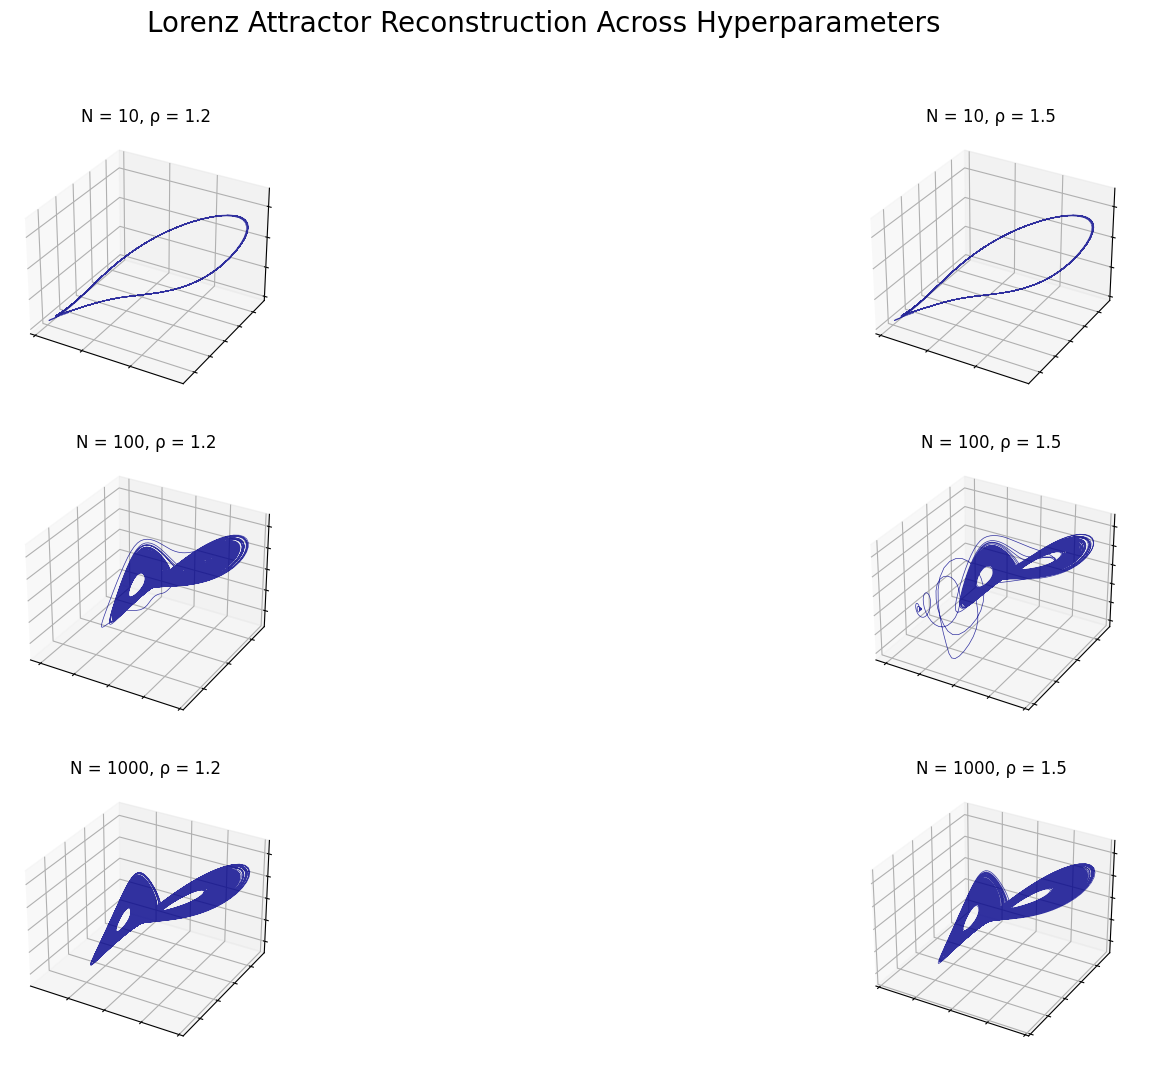

\n********************************************************************************
Grid plot finished in 86.90 seconds.
********************************************************************************\n


<Figure size 640x480 with 0 Axes>

In [14]:

import time 
def run_and_plot_on_axis(ax, N_val, rho_res_val):
    """
    Runs a single Lorenz attractor reconstruction and plots the result
    on a given matplotlib axis (ax).
    """
    print(f"Running for: N = {N_val}, ρ = {rho_res_val}...")

    global N, rho_res
    N = N_val
    rho_res = rho_res_val

    # --- Standard RC Pipeline ---
    # 1. Initialization
    M, W_in = generate_reservoir_matrices(N, P, rho_res, random_seed)
    total_time = t_listen + t_train + t_predict
    u_series, _ = generate_lorenz_data(total_time, dt, lorenz_ic)

    # 2. Listening (Washout)
    r_after_listening = listening_phase(u_series, M, W_in, t_listen, dt)

    # 3. Training
    W_out, r_after_training = training_phase(u_series, r_after_listening,
                                            M, W_in, t_listen, t_train, dt)

    # 4. Prediction
    u_pred, _ = prediction_phase(r_after_training, M, W_in, W_out,
                                 t_predict, dt)

    # --- Plotting on the provided subplot axis 'ax' ---
    ax.plot(u_pred[0, :], u_pred[2, :],u_pred[1,:],
             'darkblue', alpha=0.8, linewidth=0.5)
    ax.set_title(f'N = {N_val}, ρ = {rho_res_val}', fontsize=12)
    # Turn off axis labels to keep the grid clean
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])


# ============================================================================
# MAIN HYPERPARAMETER SWEEP
# ============================================================================

if __name__ == "__main__":
    # Define the parameter values you want to test
    N_values = [ 10, 100, 1000]
    rho_res_values = [ 1.2, 1.5]

    start_time = time.time()

    # Create a single figure with a grid of subplots
    # The grid size is determined by the number of parameters to test
    fig, axes = plt.subplots(len(N_values), len(rho_res_values),
                             figsize=(20, 12),  # Adjust figsize for your screen
                             subplot_kw={'projection': '3d'})

    fig.suptitle('Lorenz Attractor Reconstruction Across Hyperparameters', fontsize=20)

    # Loop through all combinations using enumerate to get indices for plotting
    for i, n_val in enumerate(N_values):
        for j, rho_val in enumerate(rho_res_values):
            # Pass the correct subplot axis to the function
            run_and_plot_on_axis(axes[i,j], n_val, rho_val)

    # Adjust layout to prevent titles from overlapping
    plt.tight_layout(w_pad=0.3,h_pad=0.2)
    # Show the single, complete figure with all plots
    plt.show()
    plt.savefig(str('N_vs_rho.pdf'),transparent=True,bbox_inches='tight')

    end_time = time.time()
    print(f"\\n{'*'*80}")
    print(f"Grid plot finished in {end_time - start_time:.2f} seconds.")
    print(f"{'*'*80}\\n")

